In [1]:
import os
from Models.binary_semantic_segmentation import unet
from Loss_Functions.binary_semantic_segmentation_loss import dice_coef_loss, dice_coef
import tensorflow as tf
import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
from matplotlib import pyplot as plt
print('Running TF version ', tf.__version__)

Running TF version  2.4.1


In [3]:
# If this says 0 GPUs available, your TF version is wrong. Install tensorflow-gpu >= 2 (I used v 2.4.1)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# We'll use Keras' ImageDataGenerator to feed data to the network during training. The data generator will
> ## 1) Augment the training data, rescale the training data, convert the training masks to single channel grayscale
> ## 2) Rescale the validation data, convert the validation masks to single channel grayscale

In [4]:
# these directories were made in the Pre-Prossing noteboo
train_img_dir = 'data/training/images/'
train_mask_dir = 'data/training/masks/'

val_img_dir = 'data/validation/images/'
val_mask_dir = 'data/validation/masks/'

In [5]:
image_size = (512,512) # this should match the pre-processing image chip dimensions (excludes number of channels)
BATCH_SIZE = 4 # I think this gets close to maxing out the gpu for 512x512 images
train_seed = 909

# 1a)initialize the training data generator 
## Note: The 'nearest' image interpolation seems busted in this version (2.4.1) of tensorflow,
## causing issues with rotation, zoom, or other resizing augmentation on the binary 
## masks, cauing the masks to no longer be binary. Write a custom data generator
## if you want to use resizing augmentation, or it might be fixed in later TF versions. 

train_datagen = ImageDataGenerator(rescale=1.0/255.0,horizontal_flip=True,
                                   vertical_flip=True)

# 1b) apply the data flow. Masks will be converted to single channel grayscale.
train_img_flow = train_datagen.flow_from_directory(directory=train_img_dir,
                                          class_mode=None, seed=train_seed, 
                                          target_size=image_size, batch_size=BATCH_SIZE)


train_mask_flow = train_datagen.flow_from_directory(directory=train_mask_dir, color_mode='grayscale',
                                            class_mode=None, seed=train_seed, 
                                            target_size=image_size, batch_size=BATCH_SIZE)

# 2a) initialize the validation data generator
val_seed = 10
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# 2b) apply the data flow. Masks will be converted to single channel grayscale.
val_img_flow = val_datagen.flow_from_directory(directory=val_img_dir,
                                          class_mode=None, seed=val_seed, 
                                          target_size=image_size, batch_size=BATCH_SIZE)
val_mask_flow = val_datagen.flow_from_directory(directory=val_mask_dir, color_mode='grayscale',
                                            class_mode=None, seed=val_seed, 
                                            target_size=image_size, batch_size=BATCH_SIZE)


# 3) Finalize the generators for training and validation. These will get passed to the model.fit() when training. 
train_generator = zip(train_img_flow, train_mask_flow)

val_generator = zip(val_img_flow,val_mask_flow)

Found 579 images belonging to 1 classes.
Found 579 images belonging to 1 classes.
Found 245 images belonging to 1 classes.
Found 245 images belonging to 1 classes.


# Check the outputs from the data generators

In [6]:
xy = next(train_generator) # get an image and mask from the training generator
v_xy = next(val_generator) # get an image and mask from the validation generator

In [7]:
print(type(xy), type(xy[0]), type(xy[1])) # check the train types output by the generator
print(type(v_xy), type(v_xy[0]), type(v_xy[1])) # check the validation types output by the generator
print(xy[0].shape, xy[1].shape) # (training images tensor shape, training masks tensor shape) (batchsize, imrows, imcols, imchannels)
print(v_xy[0].shape, v_xy[1].shape) # (validation images tensor shape, validation masks tensor shape) (batchsize, imrows, imcols, imchannels)
print((np.min(xy[0]),np.max(xy[0])), (np.min(v_xy[0]),np.max(v_xy[0])))# check that the training and val images are normalized
print((np.min(xy[1]),np.max(xy[1])), (np.min(v_xy[1]),np.max(v_xy[1])))# check that the training and val masks are normalized
print(np.unique(xy[1]), np.unique(v_xy[1])) # check that the training and val masks are binary

<class 'tuple'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'tuple'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(4, 512, 512, 3) (4, 512, 512, 1)
(4, 512, 512, 3) (4, 512, 512, 1)
(0.0, 1.0) (0.0, 1.0)
(0.0, 1.0) (0.0, 1.0)
[0. 1.] [0. 1.]


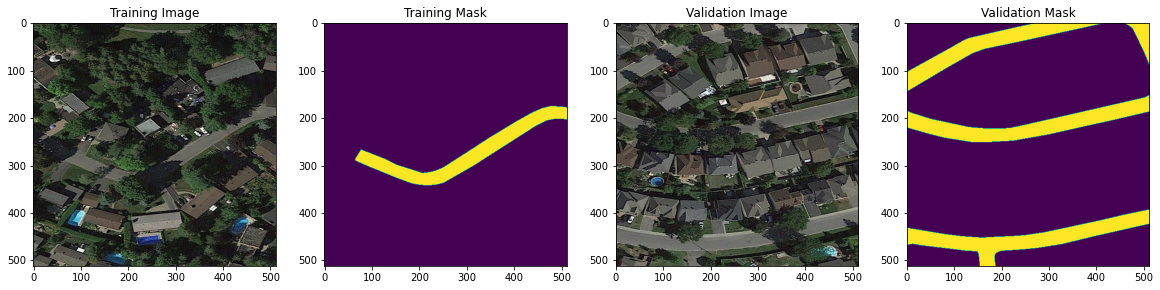

In [8]:
fig, ax = plt.subplots(1,4,figsize=(20,10))
ax[0].imshow(xy[0][0,:,:])
ax[1].imshow(xy[1][0,:,:,0])
ax[2].imshow(v_xy[0][0,:,:])
ax[3].imshow(v_xy[1][0,:,:,0])
ax[0].set_title('Training Image');
ax[1].set_title('Training Mask');
ax[2].set_title('Validation Image');
ax[3].set_title('Validation Mask');

# Next we'll establish the Unet Architecture 

In [9]:
# instantiate the model
model = unet(shape = (512, 512,3,), OUTPUT_CHANNELS = 1)

# see the resulting model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Make a folder for saving the trained weights and TF event files

In [10]:
if os.path.isdir('Unet_Ottawa_Weights'):
    now = datetime.datetime.now()
    timestamp = now.strftime("%d_%m_%Y_%H_%M_%S")
    os.rename('Unet_Ottawa_Weights','Unet_Ottawa_Weights_'+timestamp)
    print('Renamed existing Unet_Ottawa_Weights to '+'Unet_Ottawa_Weights_'+timestamp)
    os.makedirs('Unet_Ottawa_Weights')
    print('Made directory Unet_Ottawa_Weights')
else:
    os.makedirs('Unet_Ottawa_Weights')
    print('Made directory Unet_Ottawa_Weights')

Made directory Unet_Ottawa_Weights


# Set the number of epochs and calculate the steps (batches) per epoch

In [11]:
EPOCHS = 60
STEPS_PER_EPOCH = len(os.listdir(train_img_dir+'/images')) // BATCH_SIZE # number of images divided by the batch size
VALIDATION_STEPS = len(os.listdir(val_img_dir+'/images')) // BATCH_SIZE
print(EPOCHS, STEPS_PER_EPOCH, VALIDATION_STEPS)

60 144 61


# Configure the optimizer, lr, loss, and metrics for training

In [12]:
## Exponential LR Decay
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=STEPS_PER_EPOCH*20,
    decay_rate=0.5,
    staircase=True) # apply exponental LR decay every ten epochs

## If you want a fixed learning rate, just pass this into the optimizer instead of the lr_schedule
# learning_rate=0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule), 
              loss=dice_coef_loss,
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                       tf.keras.metrics.MeanIoU(num_classes=2,name='iou'),
                      dice_coef])

# Configure the callbacks (metrics, Tensorboard)

In [13]:
checkpoint_filepath = 'Unet_Ottawa_Weights/weights.{epoch:02d}-{val_loss:.2f}.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='Unet_Ottawa_Weights', histogram_freq=1)

# Train the network. Weights and events will be saved in the "Unet_Ottawa_Weights" directory

In [14]:
model_history = model.fit(train_generator,epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          callbacks=[model_checkpoint_callback,tensorboard_callback],
                         validation_data=val_generator,
                         validation_steps=VALIDATION_STEPS)

Epoch 1/60
144/144 [==============================] - 203s 1s/step - loss: 0.5002 - accuracy: 0.8137 - iou: 0.4469 - dice_coef: 0.4998 - val_loss: 0.6862 - val_accuracy: 0.8990 - val_iou: 0.4390 - val_dice_coef: 0.3145
Epoch 2/60
144/144 [==============================] - 65s 453ms/step - loss: 0.3285 - accuracy: 0.9101 - iou: 0.5004 - dice_coef: 0.6715 - val_loss: 0.7299 - val_accuracy: 0.8731 - val_iou: 0.4590 - val_dice_coef: 0.2698
Epoch 3/60
144/144 [==============================] - 66s 456ms/step - loss: 0.2654 - accuracy: 0.9332 - iou: 0.5801 - dice_coef: 0.7348 - val_loss: 0.1809 - val_accuracy: 0.9548 - val_iou: 0.5644 - val_dice_coef: 0.8197
Epoch 4/60
144/144 [==============================] - 65s 454ms/step - loss: 0.2406 - accuracy: 0.9412 - iou: 0.6171 - dice_coef: 0.7594 - val_loss: 0.6616 - val_accuracy: 0.8841 - val_iou: 0.5009 - val_dice_coef: 0.3379
Epoch 5/60
144/144 [==============================] - 66s 455ms/step - loss: 0.2255 - accuracy: 0.9434 - iou: 0.6413 -

Epoch 38/60
144/144 [==============================] - 66s 456ms/step - loss: 0.0924 - accuracy: 0.9777 - iou: 0.8493 - dice_coef: 0.9077 - val_loss: 0.0885 - val_accuracy: 0.9781 - val_iou: 0.8851 - val_dice_coef: 0.9124
Epoch 39/60
144/144 [==============================] - 66s 457ms/step - loss: 0.1004 - accuracy: 0.9750 - iou: 0.8512 - dice_coef: 0.8997 - val_loss: 0.0840 - val_accuracy: 0.9803 - val_iou: 0.8603 - val_dice_coef: 0.9159
Epoch 40/60
144/144 [==============================] - 66s 459ms/step - loss: 0.0862 - accuracy: 0.9784 - iou: 0.8543 - dice_coef: 0.9138 - val_loss: 0.1040 - val_accuracy: 0.9742 - val_iou: 0.8861 - val_dice_coef: 0.8961
Epoch 41/60
144/144 [==============================] - 66s 458ms/step - loss: 0.0813 - accuracy: 0.9786 - iou: 0.8522 - dice_coef: 0.9186 - val_loss: 0.0762 - val_accuracy: 0.9821 - val_iou: 0.8742 - val_dice_coef: 0.9238
Epoch 42/60
144/144 [==============================] - 66s 456ms/step - loss: 0.0863 - accuracy: 0.9786 - iou: 0

# Once network training has started, open Tensorboard in your terminal
> ## ```tensorboard --logdir Unet_Ottawa_Weights

## If you are on a remote server, you may need to set the --host correctly using ```hostname``` and your server url, e.g., 
> ## 1) In your terminal, type ```hostname``` (or ```echo ${HOSTNAME}```)
> ## 2) Prepend the hostname output to the domain name when passing to --host when starting tensorboard
> ## 3) Start tensorboard
> #### ```tensorboard --logdir Unet_Ottawa_Weights --host hostname.serverdomain.com --port 7777```

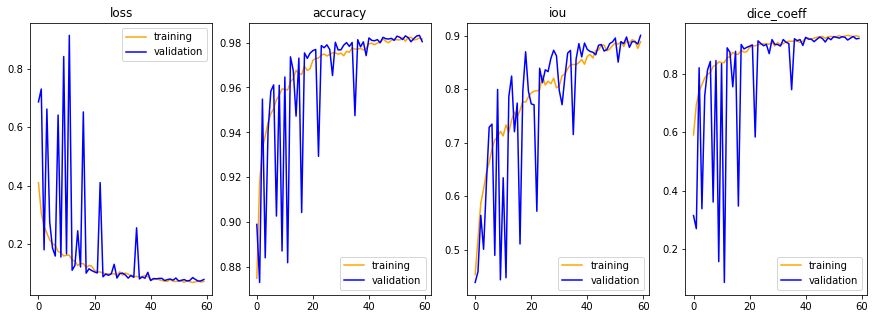

In [30]:
# Plot metrics once training has completed:
fig, ax = plt.subplots(1,4, figsize=(15,5))
ax[0].plot(model_history.history["loss"],color='orange',label="training")
ax[0].plot(model_history.history["val_loss"],color='blue',label="validation")
ax[1].plot(model_history.history["accuracy"],color='orange',label="training")
ax[1].plot(model_history.history["val_accuracy"],color='blue',label="validation")
ax[2].plot(model_history.history["iou"],color='orange',label="training")
ax[2].plot(model_history.history["val_iou"],color='blue',label="validation")
ax[3].plot(model_history.history["dice_coef"],color='orange',label="training")
ax[3].plot(model_history.history["val_dice_coef"],color='blue',label="validation")
ax[0].set_title('loss'); ax[1].set_title('accuracy'); ax[2].set_title('iou');ax[3].set_title('dice_coeff');
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend(); 

# Next we can plot images and mask predictions from the network
# If needed, you can load image weights for the model with


> ```checkpoint_path = 'Unet_Ottawa_Weights/weights.10-0.47.ckpt' ```

> ```model.load_weights(checkpoint_path)```

In [16]:
### show the available training images
#ls 'data/training/images/images/'

In [17]:
### show the available validation images
#ls 'data/validation/images/images/'

# Plot a training and validation image result

In [18]:
trained_img = cv2.imread('data/training/images/images/15_1024_512.png')[...,::-1] # VERY IMPORTANT TO FLIP CHANNELS
trained_mask = cv2.imread('data/training/masks/images/15_1024_512.png')
val_img = cv2.imread('data/validation/images/images/19_3584_1024.png')[...,::-1] # VERY IMPORTANT TO FLIP CHANNELS
val_mask = cv2.imread('data/validation/masks/images/19_3584_1024.png')
trained_img.shape, val_img.shape

((512, 512, 3), (512, 512, 3))

In [19]:
trained_result = model.predict(trained_img.reshape((1,512,512,3))/255.0)
val_result = model.predict(val_img.reshape((1,512,512,3))/255.0)
trained_result.shape, val_result.shape

((1, 512, 512, 1), (1, 512, 512, 1))

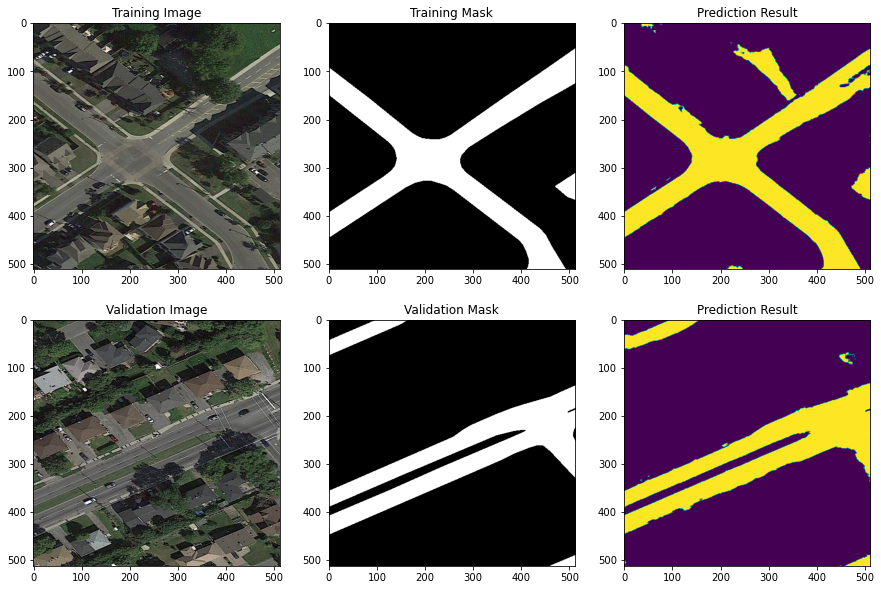

In [20]:
fig, ax = plt.subplots(2,3,figsize=(15,10))
ax[0,0].imshow(trained_img)
ax[0,1].imshow(trained_mask)
ax[0,2].imshow(trained_result[0,:,:,0])
ax[1,0].imshow(val_img)
ax[1,1].imshow(val_mask)
ax[1,2].imshow(val_result[0,:,:,0])
ax[0,0].set_title('Training Image');
ax[0,1].set_title('Training Mask');
ax[0,2].set_title('Prediction Result');
ax[1,0].set_title('Validation Image');
ax[1,1].set_title('Validation Mask');
ax[1,2].set_title('Prediction Result');